In [1]:
import os
from pathlib import Path
from typing import Optional

import fastmri
import h5py
import matplotlib.pyplot as plt
import numpy as np
import torch
from data_utils import *
from datasets import *
from fastmri.data.transforms import tensor_to_complex_np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from torch.utils.data import DataLoader, TensorDataset

from model import *
from torch.optim import SGD, Adam, AdamW
from train_utils import *

In [33]:
from pathlib import Path
import fastmri
from fastmri.data.subsample import EquiSpacedMaskFunc, RandomMaskFunc

path_to_data = '/itet-stor/mcrespo/bmicdatasets-originals/Originals/fastMRI/brain/multicoil_train/'
n_volumes = 1
center_frac = 0.15
acceleration = 4
n_slices = 2
with_mask = True

path_to_data = Path(path_to_data)
if path_to_data.is_dir():
    files = sorted(
        [
            file
            for file in path_to_data.iterdir()
            if file.suffix == ".h5" and "AXT1POST_205" in file.name
        ]
    )[:n_volumes]
else:
    files = [path_to_data]

# For each MRI volume in the dataset...
for vol_id, file in enumerate(files):
    # Load MRI volume
    with h5py.File(file, "r") as hf:
        volume_kspace = to_tensor(preprocess_kspace(hf["kspace"][()]))[
            :n_slices
        ]

    ##################################################
    # Mask creation
    ##################################################
    mask_func = EquiSpacedMaskFunc(
        center_fractions=[center_frac], accelerations=[acceleration]
    )
    shape = (1,) * len(volume_kspace.shape[:-3]) + tuple(
        volume_kspace.shape[-3:]
    )
    mask, _ = mask_func(
        shape, None, vol_id
    )  # use the volume index as random seed.

    mask, left_idx, right_idx = remove_center(mask)
    # _, left_idx, right_idx = remove_center(mask)  # NOTE: Uncomment to include the center region in the training data. Note that 'left_idx' and 'right_idx' are still needed.

    ##################################################
    # Computing the indices
    ##################################################
    n_slices, n_coils, height, width = volume_kspace.shape[:-1]
    if with_mask:
        kx_ids = torch.where(mask.squeeze())[0]
    else:
        # kx_ids = torch.arange(width)
        kx_ids = torch.from_numpy(np.setdiff1d(np.arange(width), np.arange(left_idx, right_idx))) # NOTE: Uncomment to include all the datapoints (fully-sampled volume), with the exception of the center region.
    ky_ids = torch.arange(height)
    kz_ids = torch.arange(n_slices)
    coil_ids = torch.arange(n_coils)

    kspace_ids = torch.meshgrid(kx_ids, ky_ids, kz_ids, coil_ids, indexing="ij")
    kspace_ids = torch.stack(kspace_ids, dim=-1).reshape(-1, len(kspace_ids))


(-0.5, 319.5, 319.5, -0.5)

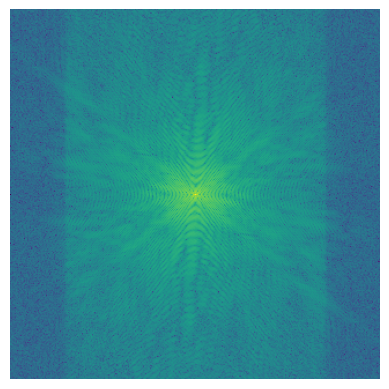

In [36]:
volume_img = torch.tensor(inverse_fft2_shift(torch.view_as_complex(volume_kspace)), dtype=torch.complex64)

vol_img_re = torch.real(volume_img)
vol_img_ph = torch.imag(volume_img)

# rss_vol = rss(volume_img)
rss_vol = np.sqrt((vol_img_re**2 + vol_img_ph**2).sum(1))
modulus = fft2_shift(rss_vol)
plt.figure()
# plt.imshow(rss_vol[0], cmap='gray')
plt.imshow(np.log(np.abs(modulus[0])))
plt.axis('off')
# for i in range(slice_img_re.shape[1]):
#     plt.figure()
#     plt.subplot(1,2,1)
#     plt.imshow(vol_img_re[0,i])
#     plt.colorbar()
#     plt.axis('off')
#     plt.subplot(1,2,2)
#     plt.imshow(vol_img_ph[0,i])
#     plt.colorbar()
#     plt.axis('off')

In [ ]:
volume_kspace

In [4]:
#####################################################################
# volume embedding
#####################################################################
embeddings_vol = torch.nn.Embedding(
    len(dataset.metadata), 256
)
torch.nn.init.normal_(
    embeddings_vol.weight.data, 0.0, 0.001
)

coil_size = []
for i in range(len(dataset.metadata)):
    _, n_coils, _, _ = dataset.metadata[i]["shape"]
    coil_size.append(n_coils)
########################################################
total_n_coils = torch.cumsum(torch.tensor(coil_size), dim=0)[-1]

start_indx = torch.tensor([0] + list(torch.cumsum(torch.tensor(coil_size), dim=0)[:-1]))

embeddings_coil = torch.nn.Embedding(total_n_coils.item(), 64)
torch.nn.init.normal_(
    embeddings_coil.weight.data, 0.0, 0.01
)

print(embeddings_coil)

Embedding(76, 64)


In [9]:
left_idx = 155
right_idx = 185
for i in range(len(start_indx)):
    # n_slices, n_coils, height, width = dataloader.dataset.metadata[i]["shape"]
    # Create tensors of indices for each dimension
    kx_ids = torch.cat([torch.arange(left_idx), torch.arange(right_idx, 320)])
    ky_ids = torch.arange(320)
    kz_ids = torch.arange(2)
    coil_ids = torch.arange(n_coils)

    # Use meshgrid to create expanded grids
    kspace_ids = torch.meshgrid(kx_ids, ky_ids, kz_ids, coil_ids, indexing="ij")
    kspace_ids = torch.stack(kspace_ids, dim=-1).reshape(-1, len(kspace_ids))

    dataset = TensorDataset(kspace_ids)
    dataloader = DataLoader(
        dataset, batch_size=60_000, shuffle=False, num_workers=3
    )
    vol_embeddings = embeddings_vol(
        torch.tensor([i] * 60_000, dtype=torch.long)
    )

    volume_kspace = torch.zeros(
        (2, n_coils, 320, 320, 2),
        dtype=torch.float32,
    )
    
    counter = 0
    for point_ids in dataloader:
        
        counter += 1
        # point_ids = point_ids[0].to(self.device, dtype=torch.long)
        point_ids = point_ids[0]
        coords = torch.zeros_like(
            point_ids, dtype=torch.float32)
        # Normalize the necessary coordinates for hash encoding to work
        coords[:, :2] = point_ids[:, :2]
        coords[:, 2] = (2 * point_ids[:, 2]) / (2 - 1) - 1
        coords[:, 3] = point_ids[:, 3]
        coil_embeddings = embeddings_coil(start_indx[i] + coords[:,3].long())
        
        if counter > 0:
            break
        


In [12]:
for module, case in zip([embeddings_vol.module, embeddings_coil.module], ["embeddings_vol", "embeddings_coil"]):
    for name, param in module.named_parameters():
        subplot_count = 1 if param.data is None else 2
        fig = plt.figure(figsize=(8 * subplot_count, 5))

        plt.subplot(1, subplot_count, 1)
        plt.hist(param.data.cpu().numpy().flatten(), bins=100, log=True)
        # plt.hist(param.data.cpu().numpy().flatten(), bins='auto', log=True)
        plt.title("Values")

        if param.grad is not None:
            plt.subplot(1, subplot_count, 2)
            # plt.hist(param.grad.cpu().numpy().flatten(), bins='auto', log=True)
            plt.hist(param.grad.cpu().numpy().flatten(), bins=100, log=True)
            plt.title("Gradients")

        tag = name.replace(".", "/")
        # self.writer.add_figure(
        #     f"params/{case}/{tag}", fig, global_step=0
        # )
        # plt.close(fig)

AttributeError: 'Embedding' object has no attribute 'module'

In [ ]:


for batch_idx, (inputs, targets) in enumerate(dataloader):
    # inputs, targets = inputs.to(self.device), targets.to(self.device)
    
    coords = inputs[:, 1:]
    vol_ids = inputs[:, 0].long()
    coil_id = inputs[:,-1].long()
    
    ## Map the coil_id to the embedding_coil_id table
    idx_start_coil = start_indx[vol_ids]
    coil_index_table = idx_start_coil + coil_id
    
    if batch_idx == 0:
        break
    
    # col_ids = inputs[:, -1].long()
    # shape = dataloader.dataset.metadata[vol_ids]["shape"]
    # latent_vol = embeddings_vol(vol_ids)
    # latent_coil = embeddings_coil[vol_ids](col_ids.unsqueeze(0))
    

In [ ]:
latent_coil = embeddings_coil(coil_index_table)

In [28]:
print(latent_coil[0])
print(latent_coil[1])

tensor([ 7.1697e-04,  1.6054e-02, -8.1535e-03, -4.3804e-03, -1.4798e-03,
         1.0080e-02,  1.5267e-03, -7.8560e-03, -1.4763e-02, -6.3897e-03,
         2.2738e-03, -4.8656e-03, -1.0216e-02,  2.7503e-02,  1.4525e-02,
         1.9802e-03, -5.4871e-03,  6.7677e-03,  1.6262e-02,  2.9267e-03,
         1.8971e-02, -1.1292e-02,  5.8535e-03, -8.5662e-03,  4.1489e-03,
        -6.2677e-03,  9.8695e-03,  9.1102e-03,  1.2742e-02, -2.8866e-02,
         1.7633e-03, -1.4269e-02, -2.2633e-03, -1.1309e-02, -2.3321e-03,
        -3.9699e-03,  1.6685e-02, -1.3623e-02,  1.0326e-03,  1.3341e-02,
        -1.6296e-02,  1.0357e-02,  2.2920e-03,  8.5684e-03, -1.2156e-02,
        -4.3018e-03,  2.7980e-02,  5.8493e-03,  1.1699e-02, -1.1763e-02,
         1.5692e-03, -1.0518e-02,  1.2219e-02,  2.8622e-03,  3.3609e-04,
        -1.2874e-02,  2.4047e-02,  4.8773e-05,  1.3925e-03, -3.4696e-03,
        -6.3902e-03,  5.2315e-03,  2.9739e-03,  1.3944e-02],
       grad_fn=<SelectBackward0>)
tensor([-0.0072, -0.0039,  0.

In [ ]:
dataloader.dataset.metadata[

TypeError: unhashable type: 'numpy.ndarray'

In [10]:
import torch
import torch.nn as nn

# Define the number of coils (Nc) for each volume and the embedding size
num_coils_per_volume = [20, 20, 16]  # Replace with actual Nc values
embedding_dim = 64

# Create a list of nn.Embedding for each volume
embeddings = nn.ModuleList([
    nn.Embedding(num_coils, embedding_dim) for num_coils in num_coils_per_volume
])

# Example input from dataloader
# input_coors = [vol_ID, kx, ky, kz, coilID] (batch_size, 5)
input_coors = torch.tensor([[0, 0.1, 0.2, 0.3, 5],  # vol_ID = 0, coilID = 5
                            [1, 0.5, 0.6, 0.7, 12],  # vol_ID = 1, coilID = 12
                            [2, 0.8, 0.9, 1.0, 7]])  # vol_ID = 2, coilID = 7

# Extract vol_IDs and coil_IDs from input_coors

# Fetch embeddings for each input coordinate
batch_embeddings = []
for coors in enumerate(input_coors):
    vol_ids = coors[:, 0].long()  # Batch of volume IDs
    coil_ids = coors[:, -1].long()  # Batch of coil IDs

    embedding_vector = embeddings[vol_ids](coil_ids.unsqueeze(0))  # Lookup for vol_id and coil_id
    batch_embeddings.append(embedding_vector)

# Combine embeddings into a batch tensor
batch_embeddings = torch.cat(batch_embeddings, dim=0)
print(batch_embeddings.shape)  # (batch_size, embedding_dim)


TypeError: tuple indices must be integers or slices, not tuple

In [24]:
inputs[:,0].long()

tensor([0, 0, 0,  ..., 0, 0, 0])